# Análisis de Series Temporales
#### Primer Trabajo Práctico
---
**Alumnos:** Novaresse, Pagani, Edgar  
**Fecha:** 10 de Julio de 2025  
**Descripción:** Forecast en variables macroeconómicas

# Producción y Consumo de Gas Natural

#### 1. Introducción
Este trabajo práctico analiza la serie temporal **"Producción y Consumo de Gas Natural'**, con datos mensuales desde enero de 1996 hasta mayo de 2025. El objetivo es modelar la serie usando ARARIMA y SARIMA, comparando su desempeño con métricas como AIC, BIC, MSE, MAE y RMSE, y generar pronósticos a 12 meses.

La serie de producción de gas natural analizada cubre el período comprendido entre enero de 1996 y mayo de 2025, con una frecuencia mensual, y cada dato representa el volumen producido expresado en millones de metros cúbicos. 

#### 2. Importar librerías necesarias

In [3]:
# Creo un environment que tenga las versiones compatibles de Numpy y PMDarima
!conda create -y -n ts_env \
    -c conda-forge \
    python=3.11 \
    numpy=1.24.4 \
    pandas \
    matplotlib \
    seaborn \
    statsmodels \
    scipy \
    pmdarima \
    scikit-learn \
    ipykernel

!conda run -n ts_env python -m ipykernel install --user --name ts_env --display-name "Python (ts_env)"

Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/ts_env

  added / updated specs:
    - ipykernel
    - matplotlib
    - numpy=1.24.4
    - pandas
    - pmdarima
    - python=3.11
    - scikit-learn
    - scipy
    - seaborn
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    statsmodels-0.14.5         |  py311h9dc9093_0        11.2 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        11.2 MB

The following NEW packages will be INSTALLED:

  appnope            conda-forge/noarch::appnope-0.1.4-pyhd8ed1ab_1 
  asttokens          conda-forge/noarch::asttokens-3.0.0-pyhd8ed1ab_1 
  brotli             conda-forge/osx-arm64::brotli-1.1.0-h5505292_3 
  brotli-bin         c

In [4]:
# Cargamos librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_ccf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, breaks_cusumolsresid
import statsmodels.api as sm
from scipy.stats import jarque_bera, shapiro, probplot, boxcox
from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest,  OCSBTest, CHTest
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from datetime import timedelta
from scipy.special import inv_boxcox
from statsmodels.stats.diagnostic import het_arch
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

----
## 3. Carga y exploración de los datos

In [5]:
# Cargamos los datos
df_gas = pd.read_csv('exportaciones-actividad-saldocomercial-rangos-exportacion-empresa-exportadora-mensual.csv', parse_dates=['indice_tiempo'])
df_gas.set_index('indice_tiempo', inplace=True) # impongo como índice las fechas
df_gas.index.freq = 'MS' # la frecuencia del índice es mensual
df_gas = df_gas[['produccion_gas_natural']] # me quedo únicamente con la columna produccion_gas_natural
df_gas.head()

,produccion_gas_natural
indice_tiempo,
1996-01-01,2504.98
1996-02-01,2325.37
1996-03-01,2735.07
1996-04-01,2584.15
1996-05-01,3006.48


In [6]:
# Verificamos que el indice sea del tipo DatetimeIndex y frecuencia mensual
print(df_gas.index)

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01'],
              dtype='datetime64[ns]', name='indice_tiempo', length=353, freq='MS')


In [7]:
# Verificamos la existencia de valores nulos
print("Valores faltantes:")
print(df_gas.isnull().values.any())

Valores faltantes:
False


In [8]:
# Estadísticas descriptivas
print("Estadísticas Descriptivas:")
print(df_gas.describe())

Estadísticas Descriptivas:
       produccion_gas_natural
count              353.000000
mean              3837.177348
std                466.661870
min               2325.370000
25%               3547.854901
50%               3840.152971
75%               4152.315067
max               5297.801606


#### Visualización y descomposición de la serie 

In [9]:
# Función para graficar
def graficar(serie, titulo='', xlabel='', ylabel='', figsize=(10, 3), usar_leyenda=False, label=''):
    plt.figure(figsize=figsize)
    if usar_leyenda:
        plt.plot(serie, label=label)
        plt.legend()
    else:
        plt.plot(serie)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

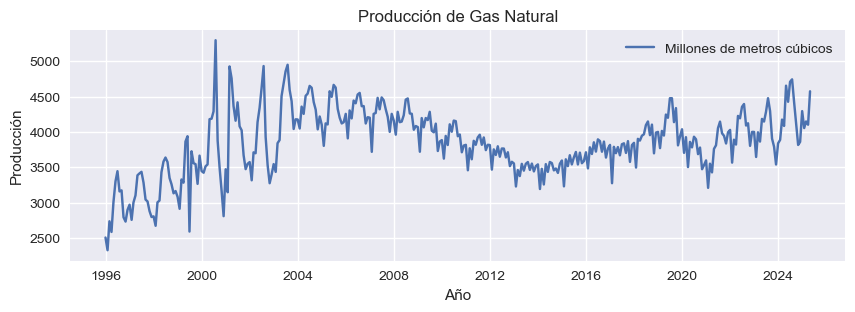

In [ ]:
# Visualizamos los datos
graficar(df_gas['produccion_gas_natural'], titulo='Producción de Gas Natural',
         xlabel='Año', ylabel='Producción', figsize=(10, 3),
         usar_leyenda=True, label='Millones de metros cúbicos')

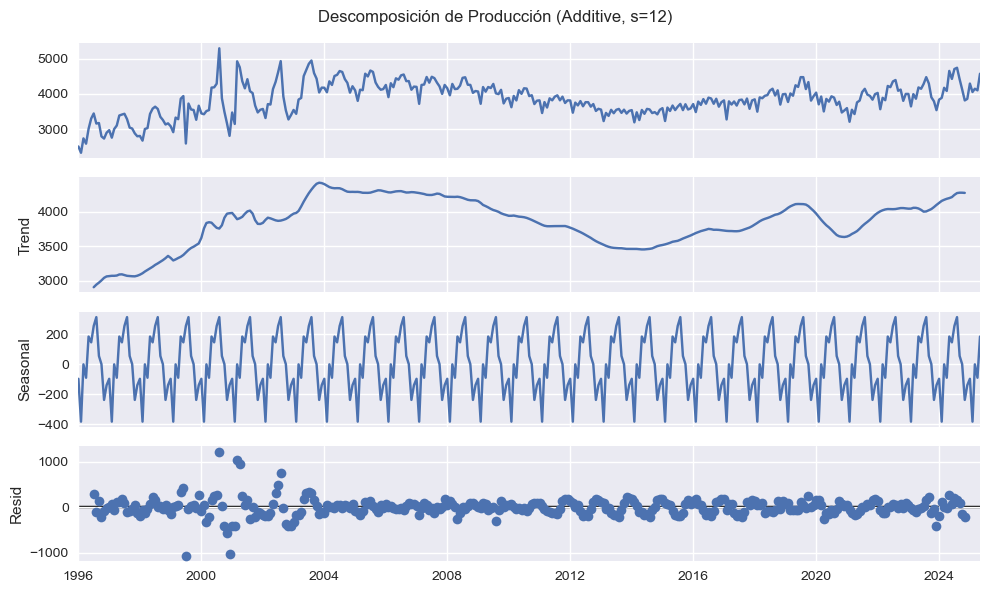

In [11]:
# Descomposición de la serie en diferentes componentes
decomp = seasonal_decompose(df_gas, model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(10, 6)
plt.suptitle('Descomposición de Producción (Additive, s=12)')
plt.tight_layout()
plt.show()

- La **tendencia** revela un comportamiento no estacionario, lLa media de la serie no se mantiene constante a lo largo del tiempo.
- El **componente estacional** muestra un patrón cíclico anual claramente definido y de amplitud prácticamente constante durante toda la serie.
- Los **residuos** se distribuyen alrededor de cero sin evidenciar una estructura sistemática o autocorrelaciones persistentes. No obstante, se observan algunos valores atípicos en determinados períodos, como los años 1999–2001.

----
## 4. Análisis de estacionariedad

#### ACF, PACF, Autocovarianzas 

In [12]:
# Función para graficar ACF, PACF, autocovarianzas
## Fue construida a partir de la función utilizada en un notebook del profesor, y con ChatGPT se le pidió que la reformule para que sea aplicable a una serie, y no dos. 
def graficar_acf_pacf_autocov(serie, n_lags=50, titulo="Análisis de correlación temporal"):
    fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)

    fig.suptitle(titulo, fontsize=12)

    # ACF
    plot_acf(serie, lags=n_lags, ax=axes[0], color='blue', 
             vlines_kwargs={"colors": 'blue'}, title="Autocorrelación (ACF)")

    # PACF
    plot_pacf(serie, lags=n_lags, ax=axes[1], color='green', 
              vlines_kwargs={"colors": 'green'}, method='ywm', title="Autocorrelación Parcial (PACF)")

    # Autocovarianzas
    autocov = tsa.acovf(serie, fft=False, nlag=n_lags)
    axes[2].plot(autocov, color='red')
    axes[2].set_title("Autocovarianzas")
    axes[2].set_xlabel("Lag")

    plt.tight_layout()
    plt.show()

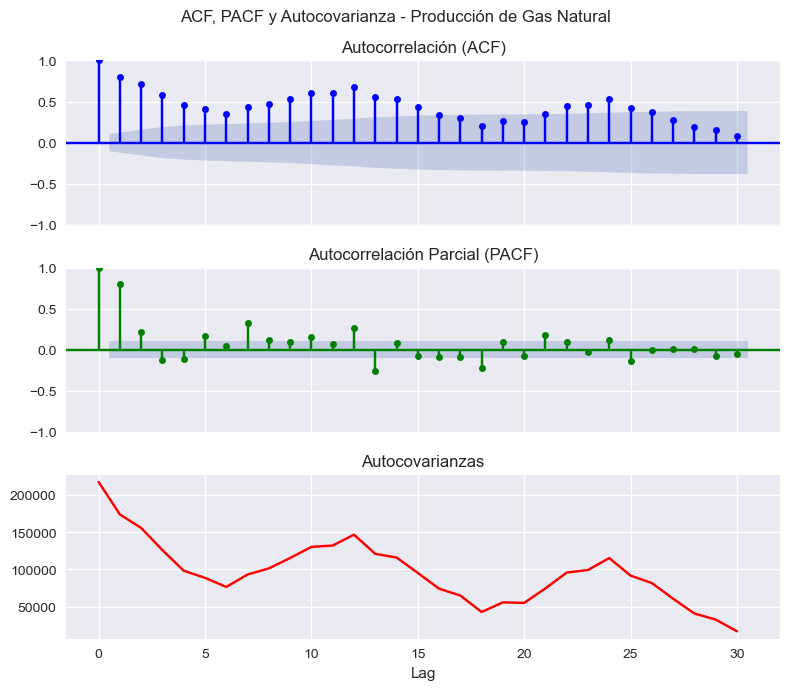

In [13]:
# Graficamos 
graficar_acf_pacf_autocov(df_gas, n_lags=30, 
                          titulo="ACF, PACF y Autocovarianza - Producción de Gas Natural")

- La **ACF** muestra una caída lenta y gradual, con valores significativamente distintos de cero incluso después de varios rezagos (lags), lo que sugiere no estacionariedad. 
- La **PACF** indica que el primer rezago es muy significativo y los siguientes caen rápidamente cerca de cero. Esto sugiere que un modelo AR(1) podría ser adecuado, ya que la mayor parte de la dependencia se explica con el primer rezago.
- Las **autocovarianzas** también disminuyen con el lag, lo que refuerza la idea de que la serie tiene dependencia temporal, pero esta se va perdiendo a medida que aumenta el lag.

#### Análisis de la primera diferencia de la serie

In [14]:
# Aplicamos primera diferencia, para ver si se puede eliminar la estacionariedad
gas_diff = df_gas.diff().dropna()

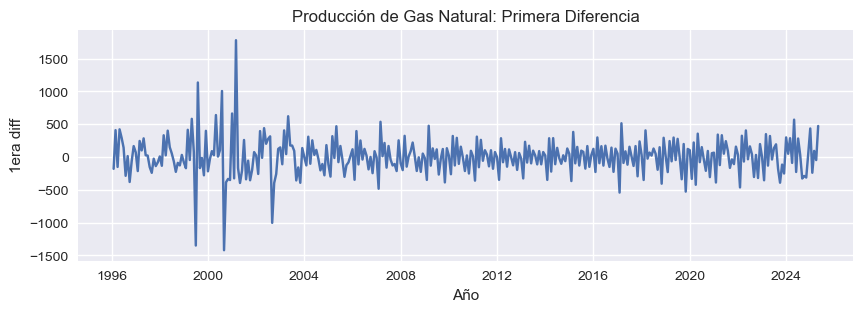

In [15]:
# Graficamos la primera diferencia
graficar(gas_diff, 
         titulo='Producción de Gas Natural: Primera Diferencia', 
         xlabel='Año', 
         ylabel='1era diff', 
         figsize=(10, 3))

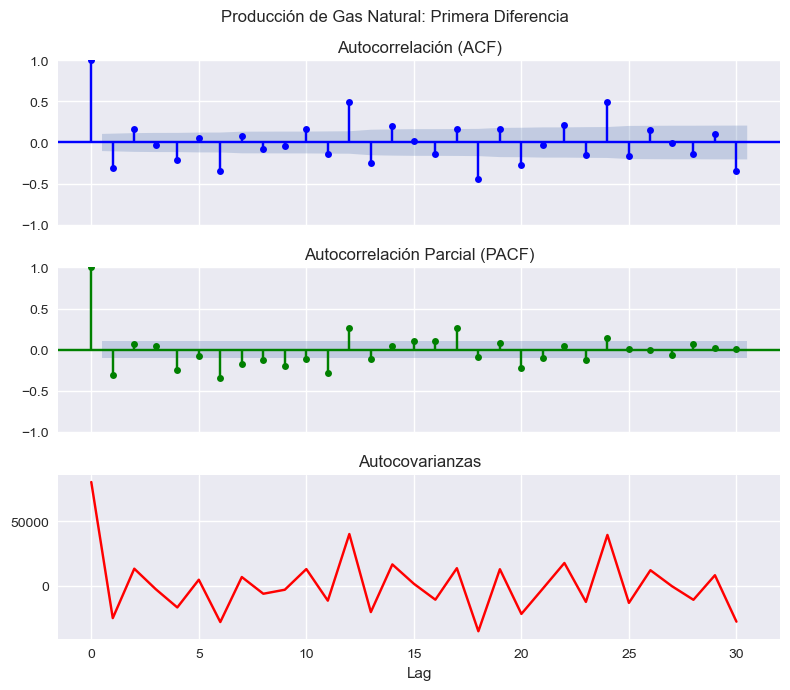

In [16]:
# Y su ACF, PACF y autocovarianzas
graficar_acf_pacf_autocov(gas_diff, n_lags=30, 
                          titulo="Producción de Gas Natural: Primera Diferencia")

- La **ACF** cae rápidamente a valores cercanos a cero después del primer rezago, y la mayoría de los valores están dentro del intervalo de confianza. Esto indica que la serie diferenciada es probablemente estacionaria, 
- En el gráfico de **PACF**, solo el primer rezago es claramente significativo, mientras que los siguientes están cerca de cero. Esto sugiere que, tras la diferenciación, la dependencia temporal se ha reducido considerablemente y un modelo ARMA simple podría ser adecuado.
- Las **autocovarianzas** oscilan alrededor de cero y no muestran una tendencia clara, lo que también es característico de una serie estacionaria.

#### Test Dickey-Fuller Aumentado

In [17]:
# Función para realizar test ADF
# Se utiliza el mismo que proporcionó el profesor en la clase de práctica
# Se incorporó un componente adicional expresa si se rechaza o no la hipótesis nula del test, construido con ChatGPT

def print_test_adf(y):
    resultado = adfuller(y.dropna())
    estadistico_adf = resultado[0]
    p_valor = resultado[1]
    criticos = resultado[4]

    print('Estadístico ADF: %f' % estadistico_adf)
    print('p-valor: %f' % p_valor)
    print('Valores críticos:')
    for clave, valor in criticos.items():
        print(f'   {clave}: {valor:.3f}')

    if p_valor < 0.05:
        print("Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.")
    else:
        print("No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.")

In [18]:
# Testeamos la serie sin diferenciar
print_test_adf(df_gas)

Estadístico ADF: -2.306551
p-valor: 0.169864
Valores críticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.


In [ ]:
# Testeamos la serie diferenciada
print_test_adf(gas_diff)

Estadístico ADF: -4.048155
p-valor: 0.001178
Valores críticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


Los resultados de los tests ADF también indican que la serie requiere una diferenciación (d=1) para alcanzar estacionariedad.

#### Test KPSS

In [ ]:
from statsmodels.tsa.stattools import kpss

def test_kpss(serie, regression='c'):
    print(f"--- KPSS Test (regression='{regression}') ---")
    statistic, p_value, lags, crit_values = kpss(serie, regression=regression, nlags='auto')
    print(f'Estadístico KPSS: {statistic:.4f}')
    print(f'p-valor: {p_value:.4f}')
    print(f'Lags usados: {lags}')
    print('Valores críticos:')
    for key, value in crit_values.items():
        print(f'   {key}: {value}')
    if p_value < 0.05:
        print("❌ Se rechaza la hipótesis nula: la serie NO es estacionaria.")
    else:
        print("✅ No se rechaza la hipótesis nula: la serie es estacionaria.")
    print()

# Ejemplo de uso:
test_kpss(df_gas['produccion_gas_natural'], regression='c')  # Solo constante
test_kpss(df_gas['produccion_gas_natural'], regression='ct') # Constante y tendencia

--- KPSS Test (regression='c') ---
Estadístico KPSS: 0.5498
p-valor: 0.0304
Lags usados: 10
Valores críticos:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
❌ Se rechaza la hipótesis nula: la serie NO es estacionaria.

--- KPSS Test (regression='ct') ---
Estadístico KPSS: 0.3969
p-valor: 0.0100
Lags usados: 10
Valores críticos:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216
❌ Se rechaza la hipótesis nula: la serie NO es estacionaria.



El test KPSS indica que la serie no es estacionaria, por lo que debería diferenciarse.

#### Componentes deterministicos - Test de Raíces Unitarias

In [20]:
# Función para realizar los tres test de raíces unitarias
# Función realizada con ChatGPT

def adf_test_multiple(series):
    opciones = {
        'n': 'Sin constante (None)',
        'c': 'Con constante (Drift)',
        'ct': 'Con constante y tendencia (Trend)'
    }

    for reg, descripcion in opciones.items():
        print(f"\n===== Test ADF - {descripcion} =====")
        resultado = adfuller(series.dropna(), regression=reg, autolag='AIC')
        estadistico = resultado[0]
        p_valor = resultado[1]
        criticos = resultado[4]

        print(f'Estadístico ADF: {estadistico:.4f}')
        print(f'p-valor: {p_valor:.4f}')
        print('Valores críticos:')
        for clave, valor in criticos.items():
            print(f'   {clave}: {valor:.3f}')

        if p_valor < 0.05:
            print("Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.")
        else:
            print("No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.")


In [21]:
# Testeamos la serie sin diferenciar
adf_test_multiple(df_gas)


===== Test ADF - Sin constante (None) =====
Estadístico ADF: 0.4867
p-valor: 0.8218
Valores críticos:
   1%: -2.572
   5%: -1.942
   10%: -1.616
No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estadístico ADF: -2.3066
p-valor: 0.1699
Valores críticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estadístico ADF: -2.3127
p-valor: 0.4269
Valores críticos:
   1%: -3.986
   5%: -3.424
   10%: -3.135
No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.


In [22]:
# Testeamos la serie diferenciada
adf_test_multiple(gas_diff)


===== Test ADF - Sin constante (None) =====
Estadístico ADF: -3.9807
p-valor: 0.0001
Valores críticos:
   1%: -2.572
   5%: -1.942
   10%: -1.616
Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estadístico ADF: -4.0482
p-valor: 0.0012
Valores críticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estadístico ADF: -4.0385
p-valor: 0.0077
Valores críticos:
   1%: -3.986
   5%: -3.424
   10%: -3.135
Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


Estos test siguen mostrando conclusiones coincidentes.

#### Análisis de la segunda diferencia de la serie

In [23]:
# Calculamos la serie diferenciada dos veces
gas_diff_2 = gas_diff.diff().dropna()

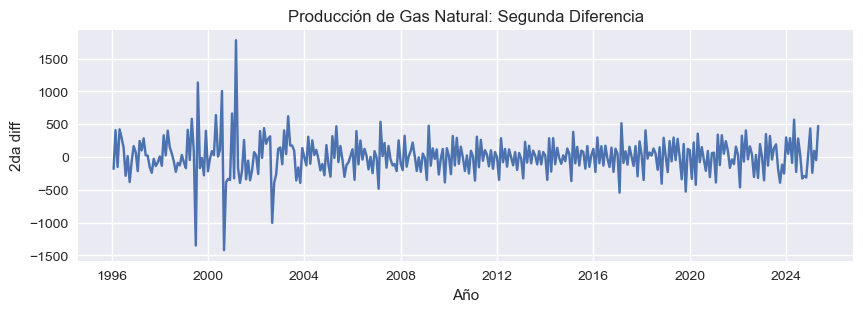

In [24]:
# Graficamos
graficar(gas_diff, 
         titulo='Producción de Gas Natural: Segunda Diferencia', 
         xlabel='Año', 
         ylabel='2da diff')

In [25]:
# Testeamos
print_test_adf(gas_diff_2)

Estadístico ADF: -10.665728
p-valor: 0.000000
Valores críticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


In [26]:
# Tesetamos raíces unitarias
adf_test_multiple(gas_diff_2)


===== Test ADF - Sin constante (None) =====
Estadístico ADF: -10.6822
p-valor: 0.0000
Valores críticos:
   1%: -2.572
   5%: -1.942
   10%: -1.616
Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estadístico ADF: -10.6657
p-valor: 0.0000
Valores críticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estadístico ADF: -10.6536
p-valor: 0.0000
Valores críticos:
   1%: -3.986
   5%: -3.424
   10%: -3.135
Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie es estacionaria.


#### Diferenciación
¿Cuántas veces debemos diferenciar? Realizamos diferentes tests para determinarlo. 

In [27]:
# Creamos una función que lleva a cabo diferentes tests de diferenciación óptima
# A partir de la proporcionada por el profesor, fine-tuneada con ChatGPT

def test_estacionariedad(y, alpha=0.05):
    print("🔍 Test de estacionariedad sugerida por distintos métodos")
    print("="*60)
    
    # Calcular cantidad de diferenciaciones sugeridas
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')

    print(f"📉 ADF test sugiere:   {n_adf} diferenciación(es)")
    print(f"📈 KPSS test sugiere: {n_kpss} diferenciación(es)")
    print(f"📉 PP test sugiere:    {n_pp} diferenciación(es)")
    print("-"*60)

    # Evaluar si al menos uno requiere diferenciación
    if any(test > 0 for test in [n_adf, n_kpss, n_pp]):
        print("Al menos uno de los tests sugiere diferenciar → Se recomienda aplicar diferenciación.")
    else:
        print("Ningún test sugiere diferenciar → La serie probablemente es estacionaria.")
    
    print("="*60)

In [28]:
test_estacionariedad(df_gas)

🔍 Test de estacionariedad sugerida por distintos métodos
📉 ADF test sugiere:   1 diferenciación(es)
📈 KPSS test sugiere: 1 diferenciación(es)
📉 PP test sugiere:    0 diferenciación(es)
------------------------------------------------------------
Al menos uno de los tests sugiere diferenciar → Se recomienda aplicar diferenciación.


In [29]:
test_estacionariedad(gas_diff)

🔍 Test de estacionariedad sugerida por distintos métodos
📉 ADF test sugiere:   0 diferenciación(es)
📈 KPSS test sugiere: 0 diferenciación(es)
📉 PP test sugiere:    0 diferenciación(es)
------------------------------------------------------------
Ningún test sugiere diferenciar → La serie probablemente es estacionaria.


Los resultados de los test de estacionariedad sugieren que es apropiado aplicar una primera diferenciación para estabilizar la serie. En consecuencia, al momento de especificar el modelo, se establece un orden de integración d=1.

----
## 5. Análisis de estacionalidad

In [30]:
# Análisis de estacionalidad a partir de una función creada con ayuda de ChatGPT

# Intuimos que la serie tiene estacionalidad cada 12 meses, por los graficos de ACF y PACF y porque es una serie con datos mensuales
# Por ello, aplicamos la 12ava diferencia a la serie original

# Test Canova-Hansen
## Para estimar el número de diferencias estacionales necesarias en la serie
def print_test_ch(series):
    resultado = CHTest(m=12).estimate_seasonal_differencing_term(series)  # m=12 
    d_seas = resultado
    print("Canova-Hansen: Número de diferencias estacionales sugeridas:", d_seas)
    if d_seas > 0:
        print("Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie tiene estacionalidad.")
    else:
        print("No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie no tiene estacionalidad.")

# Test OCSB
## Para evaluar la presencia de raíces unitarias estacionales
def print_test_ocsb(series):
    resultado = OCSBTest(m=12).estimate_seasonal_differencing_term(series)  # m=12 
    print("OCSB Test: Número de diferencias estacionales sugeridas:", resultado)
    if resultado > 0:
        print("Se rechaza la hipótesis nula con un nivel de significancia del 5%: la serie tiene estacionalidad.")
    else:
        print("No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie no tiene estacionalidad.")

# Testeamos la serie sin diferenciar
series = df_gas['produccion_gas_natural'].values

print_test_ch(series)  
print_test_ocsb(series)


Canova-Hansen: Número de diferencias estacionales sugeridas: 0
No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie no tiene estacionalidad.
OCSB Test: Número de diferencias estacionales sugeridas: 0
No se puede rechazar la hipótesis nula con un nivel de significancia del 5%: la serie no tiene estacionalidad.


Ambos tests, Canova-Hansen y OCSB, coinciden en que no es necesario aplicar diferencias estacionales a la serie.

----
## 6. Analizar la posibilidad de transformación Box-Cox

#### Test de Jarque Bera para la normalidad de los residuos

In [32]:
# Creamos una función para evaluar la normalidad con Jarque-Bera y Shapiro-Wilk con ayuda de ChatGPT
def test_normalidad(serie):
    # Test Jarque-Bera
    jb_stat, jb_pvalue = jarque_bera(serie)

    print("===== Test de Normalidad Jarque-Bera =====")
    print(f"Estadístico Jarque-Bera: {jb_stat:.4f}")
    print(f"p-valor: {jb_pvalue:.4f}")

    if jb_pvalue > 0.05:
        print("✅ No se rechaza la hipótesis nula: los residuos tienen distribución normal (al 5%)")
    else:
        print("❌ Se rechaza la hipótesis nula: los residuos NO siguen una distribución normal (al 5%)")

    print("\n===== Test de Normalidad Shapiro-Wilk =====")
    # Test Shapiro-Wilk
    shapiro_stat, shapiro_pvalue = shapiro(serie)
    print(f"Estadístico Shapiro-Wilk: {shapiro_stat:.4f}")
    print(f"p-valor: {shapiro_pvalue:.4f}")

    if shapiro_pvalue > 0.05:
        print("✅ No se rechaza la hipótesis nula: los residuos tienen distribución normal (al 5%)")
    else:
        print("❌ Se rechaza la hipótesis nula: los residuos NO siguen una distribución normal (al 5%)")

# Ejecución del test sobre la serie original
test_normalidad(df_gas)


===== Test de Normalidad Jarque-Bera =====
Estadístico Jarque-Bera: 5.5277
p-valor: 0.0630
✅ No se rechaza la hipótesis nula: los residuos tienen distribución normal (al 5%)

===== Test de Normalidad Shapiro-Wilk =====
Estadístico Shapiro-Wilk: 0.9926
p-valor: 0.0801
✅ No se rechaza la hipótesis nula: los residuos tienen distribución normal (al 5%)


Ambos test coinciden en que no es necesario aplicar la transformación Box-Cox.

---- 
## 7. Partición *train* y *test set*

Se mantiene el 90% de los datos para entrenamiento y el 10% restante para prueba, con el fin de matener una coherencia metodológica con las otras series elegidas para este trabajo.

In [33]:
# Tomamos la columna del gas como una serie
serie = df_gas[df_gas.columns[0]]

In [34]:
# Definimos el tamaño del corte: 90% para el train, 10% para el test
n_total = len(serie)
n_train = int(n_total * 0.9)

In [35]:
# División train / test
train = serie.iloc[:n_train]
test = serie.iloc[n_train:]

In [36]:
# Mostram tamaños
print(f"Observaciones totales: {n_total}")
print(f"Train: {len(train)} datos")
print(f"Test: {len(test)} datos")

Observaciones totales: 353
Train: 317 datos
Test: 36 datos


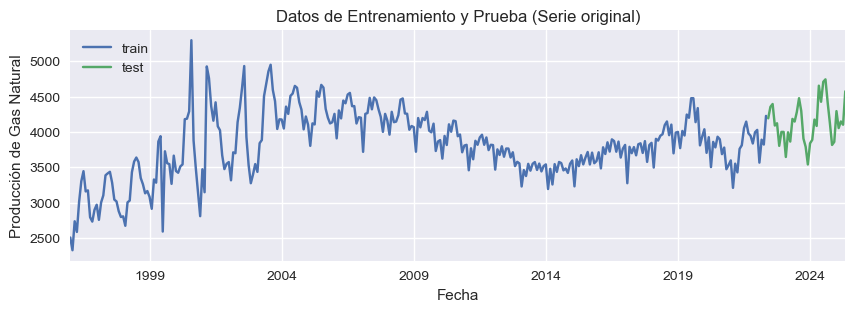

In [37]:
# Observamos los datos particionados
fig, ax = plt.subplots(figsize=(10, 3))
train.plot(ax=ax)
test.plot(ax=ax)
plt.title("Datos de Entrenamiento y Prueba (Serie original)")
plt.legend(['train', 'test'])
plt.xlabel('Fecha')
plt.ylabel('Producción de Gas Natural')
plt.show()

-----
## 8. Estimación del modelo

#### Primer modelo: ARIMA(1,1,1)

Previamente, egún los gráficos y test realizados, un modelo adecuado podría ser un **ARIMA (1,1,1)** ya que:
- d = 1: porque se aplicó la primera diferencia para lograr estacionariedad.
- p = 1: porque en la PACF solo el primer rezago es significativo.
- q = 1: porque en la ACF solo el primer rezago podría ser levemente significativo y luego cae rápidamente.
Así que es el primer modelo elegido.

In [38]:
# Modelo ARIMA
order = (1, 1, 1)

# Modelo sobre la serie original (sin Box-Cox)
modelo_arima = ARIMA(train, order=order)
results = modelo_arima.fit()

# Resumen del modelo
print(results.summary())

                                 SARIMAX Results                                  
Dep. Variable:     produccion_gas_natural   No. Observations:                  317
Model:                     ARIMA(1, 1, 1)   Log Likelihood               -2219.081
Date:                    Tue, 08 Jul 2025   AIC                           4444.163
Time:                            23:56:29   BIC                           4455.430
Sample:                        01-01-1996   HQIC                          4448.664
                             - 05-01-2022                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4328      0.100     -4.312      0.000      -0.630      -0.236
ma.L1          0.1197      0.108      1.104      0.269      -0.093       0.332
sigma2      7.373e+0

#### Segundo modelo: Grid Search para la obtención del modelo ARIMA óptimo por criterio AIC

Grid Search consiste en probar todas las combinaciones posibles de un conjunto de hiperparámetros (en este caso, los valores de p, d y q) y seleccionar la combinación que optimiza un criterio (aquí, el AIC).
En este código, se recorren todos los valores posibles definidos para p, d y q, se ajusta un modelo ARIMA para cada combinación y se guarda el modelo con el menor AIC.

In [ ]:
# Función realizada con ChatGPT

# Rangos de búsqueda
p_values = range(0, 5) 
d_values = range(0, 5)
q_values = range(0, 5)

# Variables para guardar el mejor modelo
best_aic = np.inf
best_order = None
best_model = None

# Búsqueda exhaustiva
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_model = results
            except:
                continue  # Saltea combinaciones que no converjan

# Resultados
print(f"Mejor modelo ARIMA: {best_order} con AIC: {best_aic}")
print(best_model.summary())

Mejor modelo ARIMA: (2, 4, 4) con AIC: 14.0
                                 SARIMAX Results                                  
Dep. Variable:     produccion_gas_natural   No. Observations:                  317
Model:                     ARIMA(2, 4, 4)   Log Likelihood                   0.000
Date:                    Tue, 08 Jul 2025   AIC                             14.000
Time:                            23:56:43   BIC                             40.223
Sample:                        01-01-1996   HQIC                            24.480
                             - 05-01-2022                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -1.431e-05   3.62e-09  -3952.715      0.000   -1.43e-05   -1.43e-05
ar.L2          1.0000   7.66e-08   1.31e+07      0.000 

#### Tercer modelo: Grid Search para la obtención del modelo ARIMA óptimo por criterio BIC

In [ ]:
# Rangos de búsqueda
p_values = range(0, 5)  
d_values = range(0, 5)
q_values = range(0, 5)

# Variables para guardar el mejor modelo
best_bic = np.inf
best_order = None
best_model = None

# Búsqueda exhaustiva por BIC
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                results = model.fit()

                if results.bic < best_bic:
                    best_bic = results.bic
                    best_order = (p, d, q)
                    best_model = results

            except:
                continue  # Salta combinaciones no válidas

# Resultados
print(f"Mejor modelo ARIMA por BIC: {best_order} con BIC: {best_bic}")
print(best_model.summary())

Mejor modelo ARIMA por BIC: (2, 4, 4) con BIC: 40.22342233378107
                                 SARIMAX Results                                  
Dep. Variable:     produccion_gas_natural   No. Observations:                  317
Model:                     ARIMA(2, 4, 4)   Log Likelihood                   0.000
Date:                    Tue, 08 Jul 2025   AIC                             14.000
Time:                            23:56:58   BIC                             40.223
Sample:                        01-01-1996   HQIC                            24.480
                             - 05-01-2022                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -1.431e-05   3.62e-09  -3952.715      0.000   -1.43e-05   -1.43e-05
ar.L2          1.0000   7.66e-08  

Como resultado, se obtuvo el mismo modelo óptimo que por el criterio de AIC. Así que se lo considera una sola vez.

#### Cuarto modelo: Modelo SARIMA óptimo sin intercepto

Si bien los tests de Canova-Hansen y OCSB indicaron que no es necesario realizar diferencias estacionales, gráficamente se aprecia la posible presencia de un patrón estacional. Por este motivo, a continuación se prueban modelos SARIMA con el objetivo de comparar su desempeño frente a los modelos ARIMA y, de esta forma, determinar el modelo óptimo.

In [43]:
# Función realizada con ChatGPT
 
# SARIMA óptimo SIN intercepto
print("🔍 Buscando modelo SARIMAX óptimo (sin intercepto)...")
auto_sarimax = auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=1,
    D=0,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    information_criterion='bic',
    random_state=42
)

# Ajustar el modelo óptimo con statsmodels
modelo_optimo = SARIMAX(
    train,
    order=auto_sarimax.order,
    seasonal_order=auto_sarimax.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultados_optimos = modelo_optimo.fit(disp=False)

print(f"\nMejor modelo SARIMAX por BIC: {auto_sarimax.order} x {auto_sarimax.seasonal_order} con BIC: {resultados_optimos.bic:.3f}")
print(resultados_optimos.summary())

🔍 Buscando modelo SARIMAX óptimo (sin intercepto)...
Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=4485.411, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=4387.823, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=4421.713, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=4479.769, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=4456.029, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : BIC=4351.417, Time=0.36 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : BIC=4326.997, Time=0.95 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=4321.465, Time=0.30 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=4419.814, Time=0.10 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : BIC=4327.002, Time=0.89 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : BIC=4389.650, Time=0.29 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : BIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=4336.149, Time=0.37 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   :

El modelo con menor valor de BIC en toda la lista es SARIMA(1,1,1)(1,0,1)[12] con un BIC de 4297.

In [ ]:
modelo_optimo = SARIMAX(
    serie,  
    order=(1,1,1),
    seasonal_order=(1,0,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Muestra el resumen
print(modelo_optimo.summary())

                                     SARIMAX Results                                      
Dep. Variable:             produccion_gas_natural   No. Observations:                  353
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2271.626
Date:                            Wed, 09 Jul 2025   AIC                           4553.253
Time:                                    20:06:19   BIC                           4572.368
Sample:                                01-01-1996   HQIC                          4560.871
                                     - 05-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5010      0.047     10.672      0.000       0.409       0.593
ma.L1         -0.8791      0.042   

### Validación cruzada

In [88]:
# Función realizada con ChatGPT

tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(serie):
    train_cv, test_cv = serie.iloc[train_index], serie.iloc[test_index]
    # Ajusta el modelo SARIMAX con los parámetros óptimos
    modelo_cv = SARIMAX(
        train_cv,
        order=(1,1,1),
        seasonal_order=(1,0,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred_cv = modelo_cv.forecast(steps=len(test_cv))
    mse = mean_squared_error(test_cv, pred_cv)
    mse_scores.append(mse)

print("MSE en cada fold:", mse_scores)
print("MSE promedio:", np.mean(mse_scores))

MSE en cada fold: [478803.8922685196, 562278.0442834328, 206213.75686853047, 230079.01268707745, 75276.67538027343]
MSE promedio: 310530.2762975668


- La validación cruzada temporal muestra que el modelo SARIMAX(1,1,1)(1,0,1,12) mantiene un error de predicción razonable y estable a lo largo de diferentes periodos de la serie y no hay sobreajuste a un solo periodo, lo que respalda su robustez y capacidad de generalización ya que no depende de un solo corte train/test.
- Aunque si hay cierta variabilidad entre los folds: los primeros dos tienen errores más altos, los últimos dos son intermedios y el último es el más bajo. Sin embargo, sto es normal en series temporales, especialmente si los primeros folds predicen periodos más antiguos o si hay outliers o cambios estructurales en la serie.


#### Quinto modelo: Modelo SARIMA óptimo con intercepto

In [44]:
# SARIMA óptimo CON intercepto
print("\n🔍 Buscando modelo SARIMAX óptimo (con intercepto)...")
auto_sarimax_c = auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=1,
    D=0,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    information_criterion='bic',
    random_state=42,
    trend='c'  # Intercepto
)

modelo_optimo_c = SARIMAX(
    train,
    order=auto_sarimax_c.order,
    seasonal_order=auto_sarimax_c.seasonal_order,
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultados_optimos_c = modelo_optimo_c.fit(disp=False)

print(f"\nMejor modelo SARIMAX (con intercepto) por BIC: {auto_sarimax_c.order} x {auto_sarimax_c.seasonal_order} con BIC: {resultados_optimos_c.bic:.3f}")
print(resultados_optimos_c.summary())


🔍 Buscando modelo SARIMAX óptimo (con intercepto)...
Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=4485.411, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=4387.823, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=4421.713, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=4485.411, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=4456.029, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : BIC=4351.417, Time=0.34 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : BIC=4326.997, Time=0.94 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=4321.465, Time=0.29 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=4419.814, Time=0.10 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : BIC=4327.002, Time=0.88 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : BIC=4389.650, Time=0.30 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : BIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=4336.149, Time=0.21 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   

El modelo con menor valor de BIC en toda la lista es SARIMA(1,1,1)(1,0,1)[12] con un BIC de 4297.

----
## 9. Elección de modelo
Creamos una tabla resumen con las principales características de los modelos probados

In [ ]:
# Modelo 1: ARIMA(1,1,1)
modelo_1 = ARIMA(train, order=(1, 1, 1)).fit()

# Modelo 2: ARIMA(2,4,4)
modelo_2 = ARIMA(train, order=(2, 4, 4)).fit()

# Modelo 4: SARIMAX(1,1,1)(1,0,1,12) sin intercepto
modelo_4 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,12), enforce_stationarity=False, enforce_invertibility=False).fit()

# Modelo 5: SARIMAX(1,1,1)(1,0,1,12) con intercepto
modelo_5 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,12), trend='c', enforce_stationarity=False, enforce_invertibility=False).fit()

modelos = [
    {
        'Modelo': 'Modelo 1',
        'ARIMA(p,d,q)': (1, 1, 1),
        'Seasonal(P,D,Q,s)': '-',
        'Intercepto': 'No',
        'result': modelo_1
    },
    {
        'Modelo': 'Modelo 2',
        'ARIMA(p,d,q)': (2, 4, 4),
        'Seasonal(P,D,Q,s)': '-',
        'Intercepto': 'No',
        'result': modelo_2
    },
    {
        'Modelo': 'Modelo 4',
        'ARIMA(p,d,q)': (1, 1, 1),
        'Seasonal(P,D,Q,s)': (1, 0, 1, 12),
        'Intercepto': 'No',
        'result': modelo_4
    },
    {
        'Modelo': 'Modelo 5',
        'ARIMA(p,d,q)': (1, 1, 1),
        'Seasonal(P,D,Q,s)': (1, 0, 1, 12),
        'Intercepto': 'Sí',
        'result': modelo_5
    }
]

filas = []
for m in modelos:
    res = m['result']
    pred_train = res.fittedvalues
    rmse = np.sqrt(mean_squared_error(train, pred_train))
    pvals = res.pvalues
    significativos = sum(p < 0.05 for p in pvals)
    filas.append({
        'Modelo': m['Modelo'],
        'ARIMA(p,d,q)': m['ARIMA(p,d,q)'],
        'Seasonal(P,D,Q,s)': m['Seasonal(P,D,Q,s)'],
        'Intercepto': m['Intercepto'],
        'AIC': round(res.aic, 2),
        'BIC': round(res.bic, 2),
        'RMSE Train': round(rmse, 2),
        'Coef. Significativos': f"{significativos}/{len(pvals)}"
    })

df_comparacion = pd.DataFrame(filas)
display(df_comparacion)

,Modelo,"ARIMA(p,d,q)","Seasonal(P,D,Q,s)",Intercepto,AIC,BIC,RMSE Train,Coef. Significativos
0,Modelo 1,"(1, 1, 1)",-,No,4444.16,4455.43,3.052600e+02,2/3
1,Modelo 2,"(2, 4, 4)",-,No,14.00,40.22,1.085190e+11,7/7
2,Modelo 4,"(1, 1, 1)","(1, 0, 1, 12)",No,4080.13,4098.68,2.633100e+02,5/5
3,Modelo 5,"(1, 1, 1)","(1, 0, 1, 12)",Sí,4085.10,4107.36,2.625600e+02,5/6


Sin embargo: 
#### “La precisión de los pronósticos sólo se puede determinar considerando qué tan bien se desempeña un modelo con los nuevos datos que no se utilizaron al ajustar el modelo.”
Por lo que a continuación se calcularán distintas métricas sobre el conjunto de prueba. 

#### Generación de predicciones sobre el conjunto de testeo

In [50]:
# Tamaño del set de test
n_test = len(test)
print("Tamaño del test:", n_test)

# Función para evaluar métricas
def evaluar_metricas(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print(f'MSE:  {mse:.4f}')
    print(f'MAE:  {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.2f}%')

# Pronósticos y métricas para cada modelo
# 1. Modelo 1: ARIMA(1,1,1)
pred_1 = modelo_1.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 1 ---')
evaluar_metricas(test, pred_1)
print()

# 2. Modelo 2: ARIMA(2,4,4)
pred_2 = modelo_2.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 2 ---')
evaluar_metricas(test, pred_2)
print()

# 3. Modelo 4: SARIMAX(1,1,1)(1,0,1,12) sin intercepto
pred_4 = modelo_4.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 4 ---')
evaluar_metricas(test, pred_4)
print()

# 4. Modelo 5: SARIMAX(1,1,1)(1,0,1,12) con intercepto
pred_5 = modelo_5.get_forecast(steps=n_test).predicted_mean
print('--- Métricas Modelo 5 ---')
evaluar_metricas(test, pred_5)
print()

Tamaño del test: 36
--- Métricas Modelo 1 ---
MSE:  83132.0366
MAE:  229.2465
RMSE: 288.3263
MAPE: 5.55%

--- Métricas Modelo 2 ---
MSE:  169414342029963192958976.0000
MAE:  408487498793.6555
RMSE: 411599735216.0995
MAPE: 9901042657.84%

--- Métricas Modelo 4 ---
MSE:  69908.0392
MAE:  209.2534
RMSE: 264.4013
MAPE: 4.90%

--- Métricas Modelo 5 ---
MSE:  151962.1011
MAE:  313.1273
RMSE: 389.8232
MAPE: 7.29%



### **Análisis comparativo de modelos**
**ARIMA(1,1,1)**
Este modelo logra un desempeño razonable, con un MAPE bajo (5.55%) y errores moderados. Aunque aceptable, es superado por modelos que incorporan estacionalidad.

**ARIMA(2,4,4)**
A pesar de tener los AIC/BIC más bajos, los errores de predicción (MSE, MAE, RMSE, MAPE) son desmesuradamente altos, lo que evidencia un mal ajuste o inestabilidad numérica. Debe descartarse.

**SARIMAX(1,1,1)(1,0,1)[12] sin intercepto**
Este modelo presenta los mejores resultados, con los errores más bajos en todas las métricas. Además, los coeficientes son estadísticamente significativos. Captura adecuadamente la estacionalidad y generaliza mejor que los demás modelos.

**SARIMAX(1,1,1)(1,0,1)[12] con intercepto**
Incorpora un término adicional sin mejoras relevantes. Sus errores son mayores que el mismo modelo sin intercepto. El coeficiente del intercepto no es significativo, por lo que su inclusión no se justifica.


> **Conclusión: El mejor modelo para tu serie es el SARIMAX(1,1,1)(1,0,1,12) sin intercepto.**

## Modelo seleccionado: **SARIMAX(1,1,1)(1,0,1,12)**

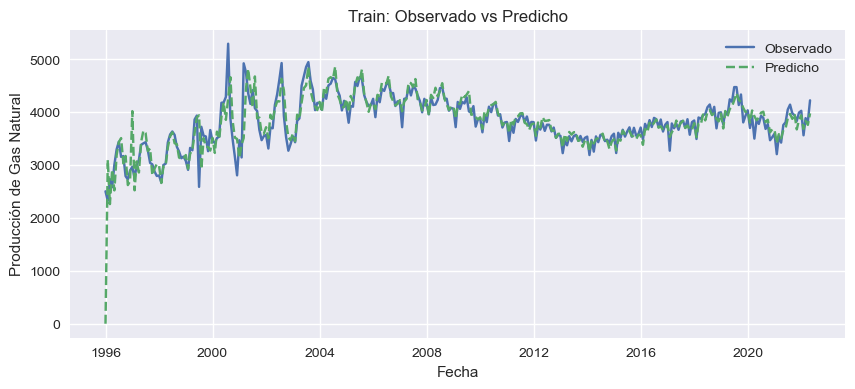

In [51]:
# Predicción en el conjunto de entrenamiento
train_pred = modelo_4.predict(start=train.index[0], end=train.index[-1])

plt.figure(figsize=(10, 4))
plt.plot(train, label='Observado')
plt.plot(train_pred, label='Predicho', linestyle='--')
plt.title("Train: Observado vs Predicho")
plt.xlabel("Fecha")
plt.ylabel("Producción de Gas Natural")
plt.legend()
plt.grid(True)
plt.show()

**Conclusiones del gráfico:**

1. **Ajuste muy bueno en el entrenamiento**
   - La línea predicha (verde, discontinua) sigue muy de cerca a la observada (azul) durante casi todo el período. Esto indica que el modelo  logra capturar muy bien la dinámica de la serie en el conjunto de entrenamiento.

2. **Captura de la estacionalidad y tendencia**
   - El modelo reproduce correctamente los picos, valles y la estacionalidad de la serie.
   - También sigue la tendencia general de la producción de gas natural a lo largo de los años.
   - Aunque hay algunos momentos (especialmente en los extremos de la serie o en picos muy abruptos) donde el modelo no logra capturar completamente la magnitud de los cambios, pero en general el ajuste es excelente.

3. **No hay signos de sobreajuste**
   - La predicción no es excesivamente “pegada” a los valores observados, lo que sugiere que el modelo es flexible pero no sobreajustado.


> **El modelo reproduce fielmente la serie histórica en el entrenamiento, capturando tanto la tendencia como la estacionalidad. Es robusto y confiable para esta serie temporal.**

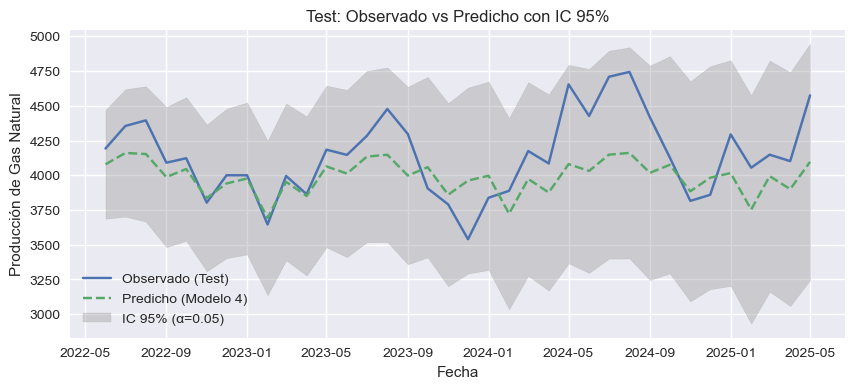

In [52]:
# Forecast y IC en el conjunto de test
n_test = len(test)
fc = modelo_4.get_forecast(steps=n_test)
pred_4 = fc.predicted_mean
ci = fc.conf_int(alpha=0.05)

plt.figure(figsize=(10, 4))
plt.plot(test.index, test, label='Observado (Test)')
plt.plot(pred_4.index, pred_4, linestyle='--', label='Predicho (Modelo 4)')

# Sombrear el intervalo de confianza
plt.fill_between(
    ci.index,
    ci.iloc[:, 0],   # límite inferior
    ci.iloc[:, 1],   # límite superior
    color='gray',
    alpha=0.3,
    label='IC 95% (α=0.05)'
)

plt.title("Test: Observado vs Predicho con IC 95%")
plt.xlabel("Fecha")
plt.ylabel("Producción de Gas Natural")
plt.legend()
plt.grid(True)
plt.show()

> El modelo SARIMAX predice bien la tendencia y la estacionalidad en el set de test, aunque suaviza los extremos. La mayoría de los valores reales caen dentro del intervalo de confianza, lo que indica que el modelo es confiable para pronóstico, aunque no perfecto para eventos abruptos.

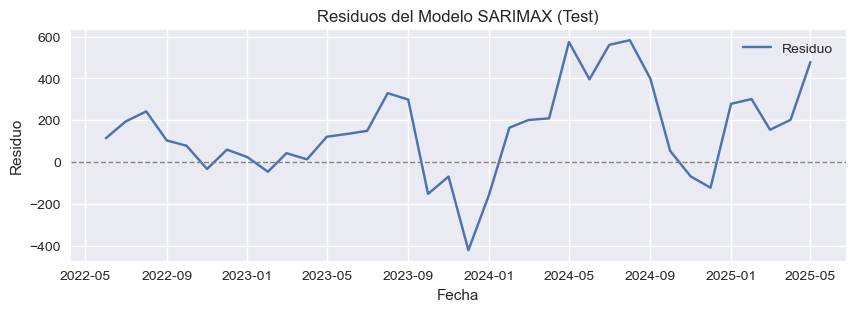

In [53]:
# Cálculo de residuos en el test
residuos_test = test - pred_4

plt.figure(figsize=(10, 3))
plt.plot(residuos_test, label='Residuo')
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title("Residuos del Modelo SARIMAX (Test)")
plt.xlabel("Fecha")
plt.ylabel("Residuo")
plt.grid(True)
plt.legend()
plt.show()

> El modelo se ajusta bien la serie: los residuos en el test están centrados en cero, no muestran patrones sistemáticos (no sobreestima ni subestima de manera constante) y su magnitud es razonable. Los errores más grandes coinciden con los picos y valles que el modelo suaviza tal cmo se observa en el gráfico anterior, pero no hay evidencia de problemas graves de ajuste. Tampoco hay evidencia de heterocedasticidad grave (varianza creciente o decreciente a lo largo del tiempo).

----
## 10. Análisis de diagnóstico

1. Gráfico de residuos en el conjunto de entrenamiento

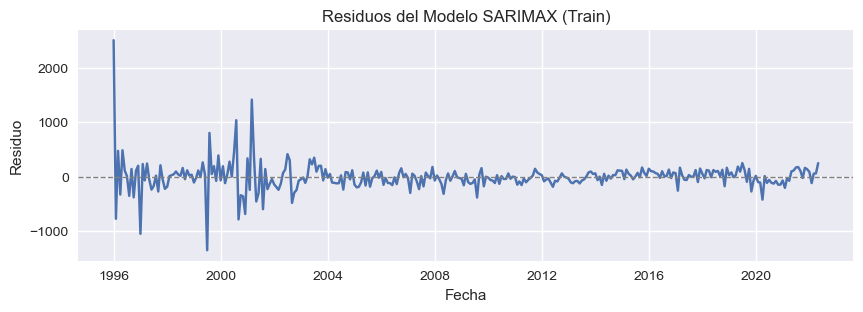

In [56]:
# Residuos del modelo en el conjunto de entrenamiento
residuos_train = modelo_4.resid

plt.figure(figsize=(10, 3))
plt.plot(residuos_train)
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title("Residuos del Modelo SARIMAX (Train)")
plt.xlabel("Fecha")
plt.ylabel("Residuo")
plt.grid(True)
plt.show()

- Adicionalmente a las conclusiones anteriores, se observan algunos residuos muy grandes (tanto positivos como negativos) al principio de la serie (antes del año 2000). Esto puede deberse a problemas de ajuste inicial del modelo o cambios estructurales o datos atípicos.
- Sin embargo, a partir del año 2000, los residuos se estabilizan y permanecen en un rango mucho más acotado, lo que indica que el modelo ajusta bien la mayor parte de la serie histórica.

2. ACF y PACF de los residuos

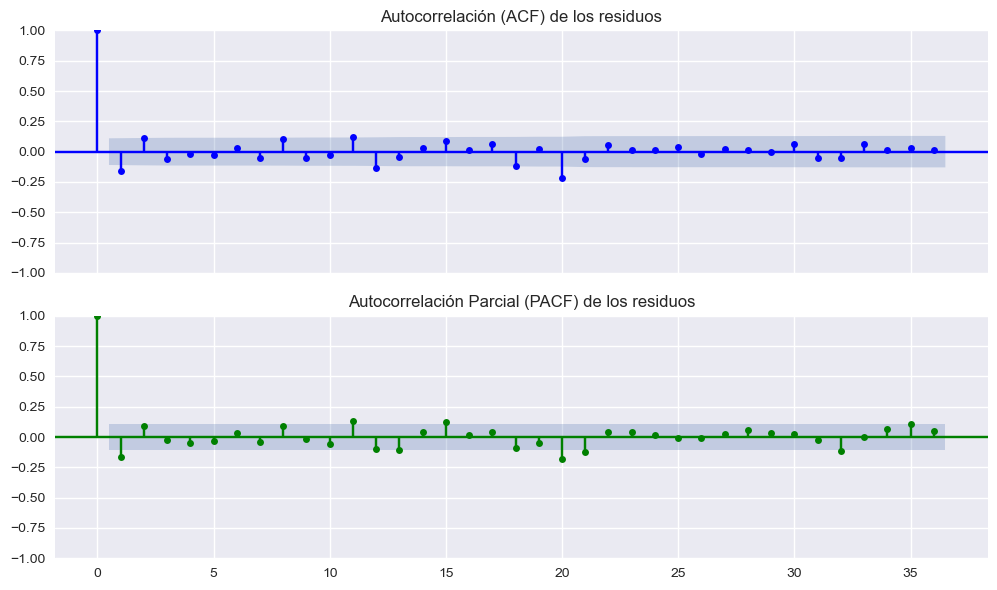

In [64]:
# Calcula los residuos del modelo en el conjunto de entrenamiento
residuos_train = modelo_4.resid

# Gráfico de ACF y PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ACF
plot_acf(residuos_train, lags=36, ax=axes[0], color='blue', vlines_kwargs={'colors':'blue'})
axes[0].set_title('Autocorrelación (ACF) de los residuos')

# PACF
plot_pacf(residuos_train, lags=36, ax=axes[1], color='green', vlines_kwargs={'colors':'green'}, method='ywm')
axes[1].set_title('Autocorrelación Parcial (PACF) de los residuos')

plt.tight_layout()
plt.show()

   - Excepto el primer lag (que siempre es 1 por definición), casi todos los valores de la ACF y PACF están dentro de la banda azul de confianza (aproximadamente ±2/√N).
   - La ausencia de autocorrelación significativa en los residuos indica que el modelo actual es suficiente para capturar la dinámica de la serie.
   - Tampoco hay patrones periódicos, lo que sugiere que los residuos son esencialmente ruido blanco.
   - El primer valor de la ACF y PACF siempre es 1, ya que es la autocorrelación de la serie consigo misma. No debe interpretarse como un problema.


3. Diagnóstico gráfico de residuos para el modelo

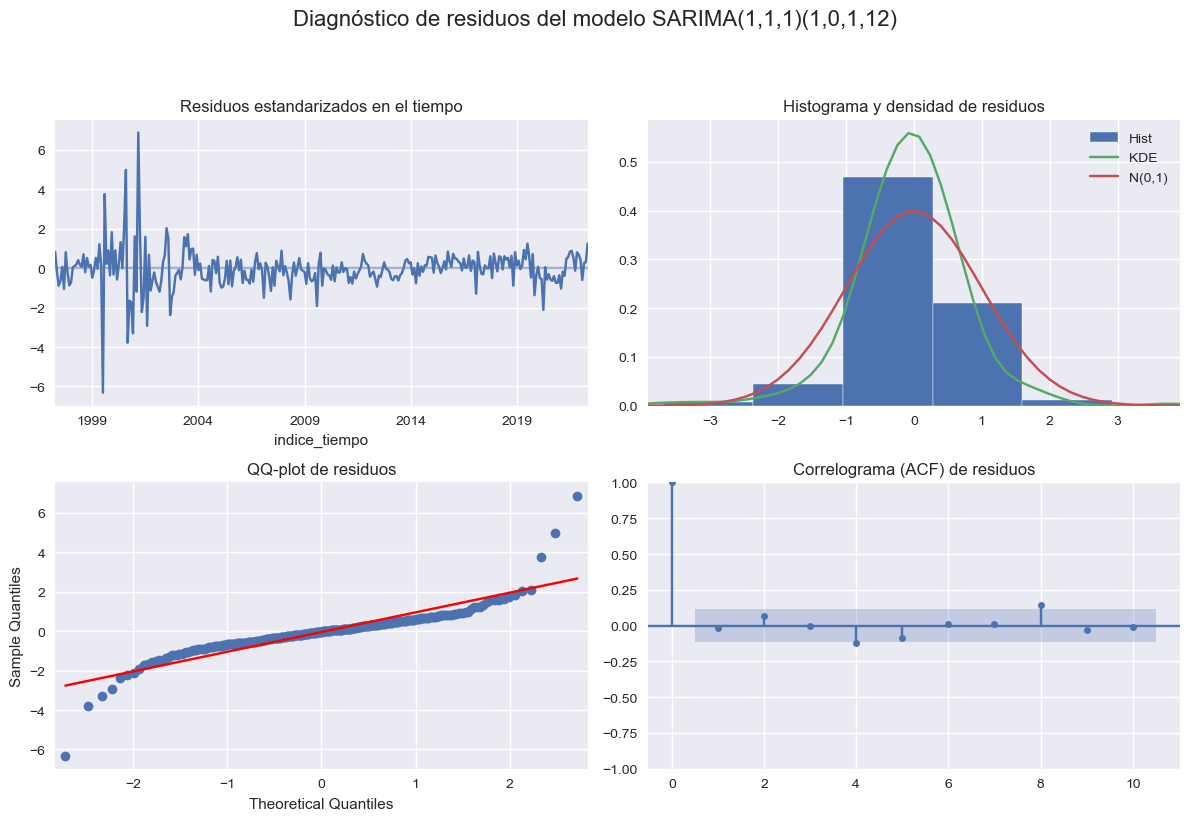

In [97]:
fig = modelo_4.plot_diagnostics(figsize=(12, 8))

# Mejorar los títulos y el espaciado
fig.suptitle("Diagnóstico de residuos del modelo SARIMA(1,1,1)(1,0,1,12)", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Ajusta el espacio para el título principal

# Opcional: puedes ajustar los títulos de los subgráficos si lo deseas
axes = fig.get_axes()
axes[0].set_title("Residuos estandarizados en el tiempo")
axes[1].set_title("Histograma y densidad de residuos")
axes[2].set_title("QQ-plot de residuos")
axes[3].set_title("Correlograma (ACF) de residuos")

plt.show()

**1. Residuos estandarizados en el tiempo**: Los residuos están centrados en torno a cero durante la mayor parte del período, aunque hay algunos valores extremos al inicio (outliers). Esto es común en series largas, especialmente si hay cambios estructurales o menor ajuste al principio; sin embargo, en la mayor parte de la serie, los residuos son pequeños y estables.

**2. Histograma de los residuos**: En general, los residuos se aproximan a la normalidad, aunque cierta asimetría y colas algo más pesadas.

**3. QQ-plot**: Nuevamente, se observa que los residuos son aproximadamente normales, hay algunos desvíos en las colas.

**4. Correlograma**: Todos los valores están dentro de las bandas de confianza, lo que indica ausencia de autocorrelación significativa en los residuos.


> Conclusión: El modelo SARIMAX ajusta bien la serie: los residuos son aproximadamente normales, no presentan autocorrelación y están centrados en cero. Los outliers al inicio no afectan el buen desempeño general.

4. Test de heterocedasticidad (ARCH)


In [86]:
residuos = modelo_4.resid

arch_test = het_arch(residuos)
print("ARCH test - Estadístico:", arch_test[0])
print("ARCH test - p-valor:", arch_test[1])

ARCH test - Estadístico: 30.176095449449072
ARCH test - p-valor: 0.0008016238793530334


- El test de heterocedasticidad ARCH indica que los residuos del modelo presentan varianza no constante a lo largo del tiempo (heterocedasticidad). Esto es común en series económicas. 
- Pero como lo que interesa es el pronóstico de la media y no de la volatilidad, la heterocedasticidad será una imitación para determinar los intervalos de confianza con cautela.

5. Test de Ljung–Box y gráfico de p-valores para residuos

      lb_stat  lb_pvalue
1    8.351720   0.003853
2   12.594773   0.001841
3   13.664519   0.003399
4   13.836870   0.007834
5   14.108450   0.014935
6   14.472377   0.024782
7   15.352281   0.031740
8   19.169871   0.013977
9   20.042137   0.017654
10  20.243002   0.027036
11  25.069297   0.008906
12  31.198860   0.001837
13  31.748427   0.002617
14  32.006163   0.003998
15  34.451532   0.002941
16  34.540815   0.004591
17  35.826169   0.004838
18  40.797138   0.001624
19  40.907689   0.002483
20  56.959934   0.000021


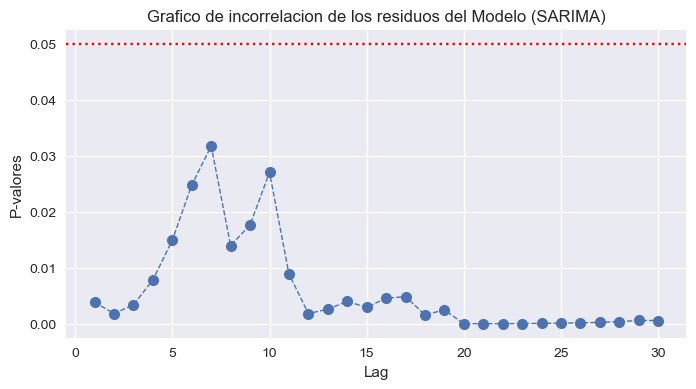

In [ ]:
# Calcula los residuos del modelo en el conjunto de entrenamiento
residuos_train = modelo_4.resid

# Test de Ljung-Box para los primeros 20 lags
ljung_box = acorr_ljungbox(residuos_train, lags=20, return_df=True)

# Mostrar la tabla de resultados
print(ljung_box)

# Gráfico de los p-valores
Incorr_residuos_modelo4 = sm.stats.acorr_ljungbox(modelo_4.resid, lags=30)
plt.figure(figsize=(8,4))
plt.plot(Incorr_residuos_modelo4.lb_pvalue, marker='o', markersize=8,
         linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del Modelo (SARIMA)")
plt.xlabel("Lag")
plt.ylabel("P-valores")
plt.axhline(0.05, color='red', linestyle=':')  # nivel de significancia 5%
plt.grid(True)
plt.show()

   - Idealmente, para un buen modelo, la mayoría de los p-valores deberían estar por encima de 0.05 (no significativos), lo que indicaría que los residuos son ruido blanco.
   - En este caso, la presencia de autocorrelación remanente sugiere que el modelo podría mejorarse, por ejemplo considerando variables exógenas. Sin embargo, primero se va a analizar si pronóstico de este modelo es suficientemente bueno para el objetivo.

6. Test de estabilidad de parámetros (CUSUM)

CUSUM statistic: 0.839740790252595
P-value: 0.48103561248603327
Critical value (5%): [(1, 1.63), (5, 1.36), (10, 1.22)]


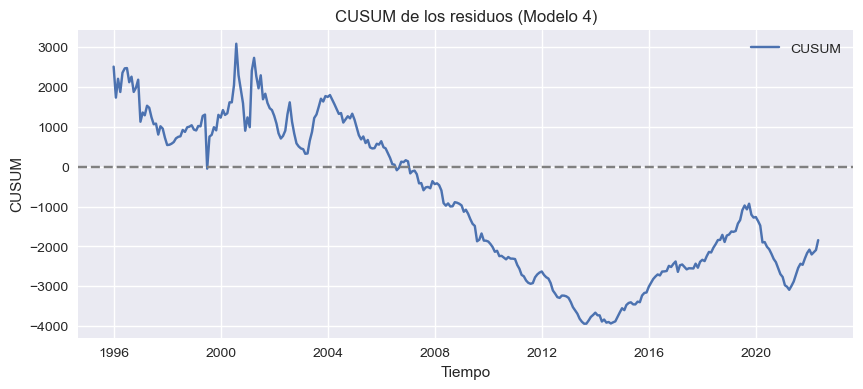

In [93]:
# Calcula los residuos del modelo 4
residuos = modelo_4.resid.dropna()

# Test CUSUM de los residuos (OLS)
cusum_stat, p_value, crit_value = breaks_cusumolsresid(residuos, ddof=0)

print(f"CUSUM statistic: {cusum_stat}")
print(f"P-value: {p_value}")
print(f"Critical value (5%): {crit_value}")

# Gráfico de la suma acumulada de residuos (CUSUM)
cusum = np.cumsum(residuos)
plt.figure(figsize=(10,4))
plt.plot(cusum, label='CUSUM')
plt.axhline(0, color='grey', linestyle='--')
plt.title("CUSUM de los residuos (Modelo 4)")
plt.xlabel("Tiempo")
plt.ylabel("CUSUM")
plt.legend()
plt.grid(True)
plt.show()

> El test CUSUM aplicado a los residuos muestra que los parámetros del modelo son estables.

----
## 11. Forecast 

1. Ajustar el modelo SARIMAX a toda la serie


In [ ]:
# Ajusta el modelo SARIMAX a toda la serie (no solo train)
model_full = SARIMAX(
    serie,
    order=(1,1,1),
    seasonal_order=(1,0,1,12),  # Usa los mejores parámetros encontrados
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_full = model_full.fit(disp=False)

# Mostrar resumen
print(results_full.summary())

                                     SARIMAX Results                                      
Dep. Variable:             produccion_gas_natural   No. Observations:                  353
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2271.626
Date:                            Wed, 09 Jul 2025   AIC                           4553.253
Time:                                    01:01:23   BIC                           4572.368
Sample:                                01-01-1996   HQIC                          4560.871
                                     - 05-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5010      0.047     10.672      0.000       0.409       0.593
ma.L1         -0.8791      0.042   

2. Pronóstico a 12 meses


In [70]:
# Pronóstico a 12 meses
n_forecast = 12
fc = results_full.get_forecast(steps=n_forecast)
pred = fc.predicted_mean
ci = fc.conf_int(alpha=0.05)

3. Crear índice futuro de 12 meses


In [71]:
last_date = serie.index[-1]
future_index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=n_forecast,
    freq=serie.index.freq or 'MS'
)
pred.index = future_index
ci.index = future_index

4. Graficar histórico + pronóstico + IC 95%


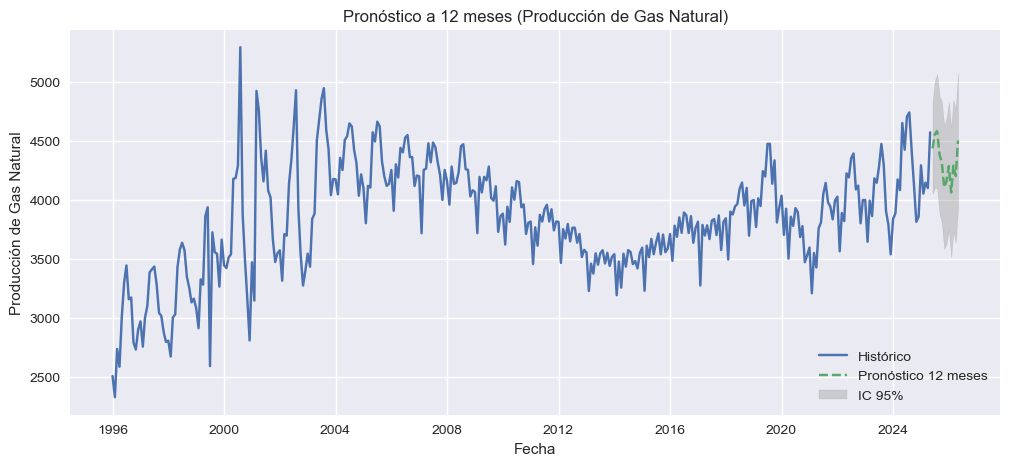

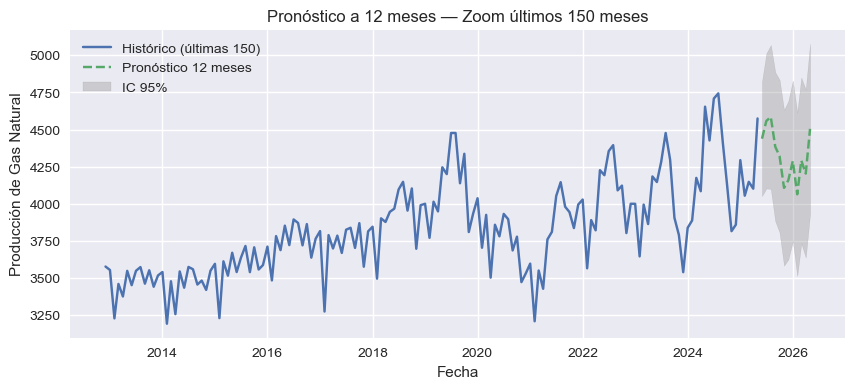

In [72]:
plt.figure(figsize=(12,5))
plt.plot(serie, label='Histórico')
plt.plot(pred, '--', label='Pronóstico 12 meses')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.3, label='IC 95%')
plt.title("Pronóstico a 12 meses (Producción de Gas Natural)")
plt.xlabel("Fecha")
plt.ylabel("Producción de Gas Natural")
plt.legend()
plt.grid(True)
plt.show()

# Zoom para ver mejor el forecast (últimos 150 meses)
hist_tail = serie.tail(150)
plt.figure(figsize=(10,4))
plt.plot(hist_tail, label='Histórico (últimas 150)')
plt.plot(pred, '--', label='Pronóstico 12 meses')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.3, label='IC 95%')
plt.title("Pronóstico a 12 meses — Zoom últimos 150 meses")
plt.xlabel("Fecha")
plt.ylabel("Producción de Gas Natural")
plt.legend()
plt.grid(True)
plt.show()